In [1]:
import os
import sys
sys.path.append(os.path.join('..', '..'))

from scripts.data_loaders.TIMIT import TIMITDataset
from scripts.data_loaders.EpaDB import EpaDBDataset
from scripts.data_loaders.PSST import PSSTDataset
from scripts.data_loaders.SpeechOcean import SpeechOceanDataset

from scripts.ipa_transcription.wav2vec2 import transcribe_batch, clear_cache, load_model
from scripts.eval.evaluate import evaluate
from scripts.core.ipa import remove_length_diacritics, remove_tones_and_stress

import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

from IPython.display import clear_output
clear_output()

In [2]:
TestSet = namedtuple('TestSet', ['name', 'data'])

testsets = [
    TestSet('TIMIT', TIMITDataset(split='test')),
    TestSet('EpaDB', EpaDBDataset(split='test')),
    TestSet('PSST', PSSTDataset(split='test', force_offline=True)),
    TestSet('SpeechOcean', SpeechOceanDataset(split='test')),
]

psstdata INFO: Loaded data version local at /Users/alex/Desktop/CS/Startups/Koel/ML/notebooks/Eval/../../scripts/data_loaders/../../.data/psst-data


In [ ]:
Model = namedtuple('Model', ['name', 'model_id'])

models = [
    Model('Facebook 53', "facebook/wav2vec2-xlsr-53-espeak-cv-ft"),
    Model('Facebook 53 Condensed', os.path.join("..", "..", "models", "facebook53_condensed")),
    Model('Facebook 60', "facebook/wav2vec2-lv-60-espeak-cv-ft"),
    Model('Koel Labs B0', "KoelLabs/xlsr-timit-b0"),
    Model('Ginic', "ginic/data_seed_4_wav2vec2-large-xlsr-buckeye-ipa"),
    Model('Speech31', "speech31/XLS-R-300m-english-ipa"),
    Model('Vitouphy', "vitouphy/wav2vec2-xls-r-300m-timit-phoneme"),
    Model('Taguchi', "ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000"),
    Model('Rubino', "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"),

    Model('FE_NL_2', os.path.join("..", "Finetuning", "runs", '7dcumy8x', 'checkpoint-8620')),
    Model('UE_SL_3', os.path.join("..", "Finetuning", "runs", 'ub9b3v0v', "checkpoint-5750")),
    Model('FE_SL_2', os.path.join("..", "Finetuning", "runs", 'u75dncsm', "checkpoint-8050")),
]

In [4]:
OUTPUT_PATH = os.path.join('..', '..', '.data', 'ipa_predictions.csv')

if os.path.exists(OUTPUT_PATH):
    output_df = pd.read_csv(OUTPUT_PATH)
else:
    output_df = pd.DataFrame(columns=[
        'dataset',
        'model_name',
        'ground_truth',
        "prediction"
    ])

In [5]:
BATCH_SIZE = 4
for model_name, model_id in models:
    clear_cache()
    model, processor = None, None
    for dataset_name, dataset in testsets:
        print(model_name, dataset_name, '...', end=" ")

        # if dataset and model combo already in df, skip
        if len(output_df) > 0 and ((output_df['dataset'] == dataset_name) & (output_df['model_name'] == model_name)).any():
            print("already done")
            continue

        if model is None or processor is None:
            model, processor = load_model(model_id)

        amount = len(dataset)
        for i in range(0, amount, BATCH_SIZE):
            clear_cache()
            size = min(BATCH_SIZE, amount - i)
            transcriptions = transcribe_batch(dataset[i:i+size], model, processor)
            for j in range(size):
                output_df = pd.concat([output_df, pd.DataFrame([[
                    dataset_name,
                    model_name,
                    dataset[i + j][0],
                    transcriptions[j]
                ]], columns=output_df.columns)])

        output_df.to_csv(OUTPUT_PATH, index=False)
        print("done")

Facebook 53 TIMIT ... already done
Facebook 53 EpaDB ... already done
Facebook 53 PSST ... already done
Facebook 53 SpeechOcean ... already done
Facebook 53 Condensed TIMIT ... already done
Facebook 53 Condensed EpaDB ... already done
Facebook 53 Condensed PSST ... already done
Facebook 53 Condensed SpeechOcean ... already done
Facebook 60 TIMIT ... already done
Facebook 60 EpaDB ... already done
Facebook 60 PSST ... already done
Facebook 60 SpeechOcean ... already done
Koel Labs B0 TIMIT ... already done
Koel Labs B0 EpaDB ... already done
Koel Labs B0 PSST ... already done
Koel Labs B0 SpeechOcean ... already done
Ginic TIMIT ... already done
Ginic EpaDB ... already done
Ginic PSST ... already done
Ginic SpeechOcean ... already done
Speech31 TIMIT ... already done
Speech31 EpaDB ... already done
Speech31 PSST ... already done
Speech31 SpeechOcean ... already done
Vitouphy TIMIT ... already done
Vitouphy EpaDB ... already done
Vitouphy PSST ... already done
Vitouphy SpeechOcean ... al

In [6]:
output_df[output_df['prediction'].isna()]

,dataset,model_name,ground_truth,prediction
19386,SpeechOcean,Koel Labs B0,ðeɪdɪdnʌtsiðɛmɛˈnimɔ,NaN
19388,SpeechOcean,Koel Labs B0,ʃimʌstbimeɪdtʌsteɪ,NaN
23493,PSST,Ginic,sksk,NaN
24415,SpeechOcean,Ginic,hɪʌɪzmɛˈɝɪsʃuz,NaN
25470,SpeechOcean,Ginic,ðeɪdɪdnʌtsiðɛmɛˈnimɔ,NaN
25472,SpeechOcean,Ginic,ʃimʌstbimeɪdtʌsteɪ,NaN
37640,SpeechOcean,Vitouphy,ʃimʌstbimeɪdtʌsteɪ,NaN
53362,PSST,Facebook 53 Condensed,aɪdoʊnoʊ,NaN
53926,PSST,Facebook 53 Condensed,hɔɹs,NaN
61961,SpeechOcean,FE_NL_2,ðeɪdɪdnʌtsiðɛmɛˈnimɔ,NaN


In [7]:
# drop failed rows
output_df.dropna(inplace=True)

In [10]:
def remove_bad_model_vocab(ipa):
    ipa = ''.join(c for c in ipa if not c.isdigit()).lower().replace("#", "").replace("ɔ̇", "ɔ")
    return remove_length_diacritics(remove_tones_and_stress(ipa)).replace(".", "").replace('̪', '').replace("[", "")

In [11]:
output_df[["per", "fer"]] = output_df.parallel_apply(lambda x: pd.Series(evaluate(remove_bad_model_vocab(x['ground_truth']), remove_bad_model_vocab(x['prediction']), simplify=False)), axis=1) # type: ignore

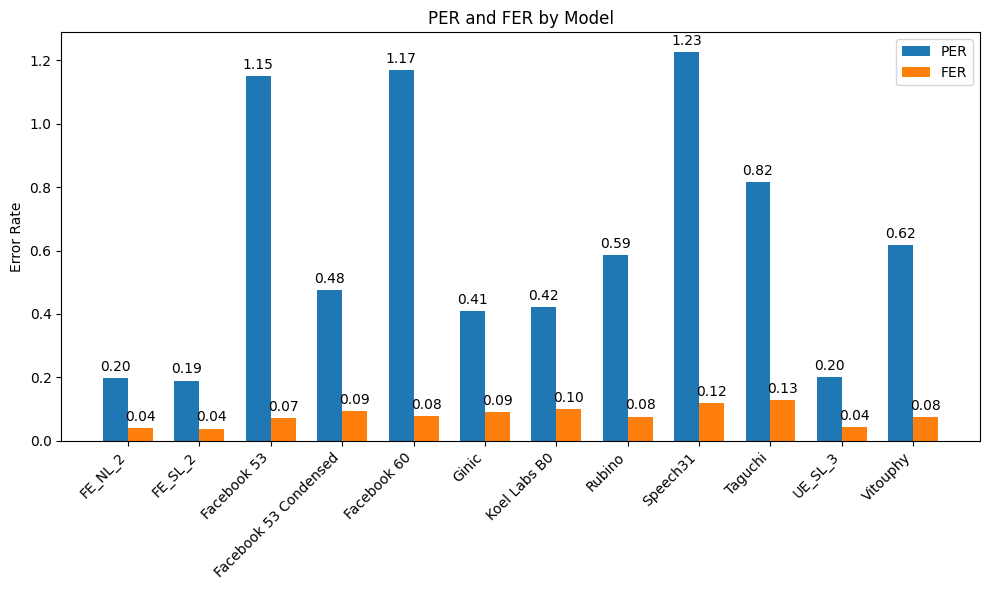

In [12]:
# plot per and fer by model as bar chart with two bars per model (one for per and one for fer)
# models = ['Facebook 53', 'Facebook 60', 'Koel Labs B0', 'Vitouphy']
models = sorted(output_df['model_name'].unique())
agg_df = output_df[output_df["model_name"].isin(models)].groupby("model_name")[["per", "fer"]].mean().reset_index()
x = np.arange(len(agg_df["model_name"]))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, agg_df["per"], width, label='PER')
bars2 = ax.bar(x + width/2, agg_df["fer"], width, label='FER')

# Add labels and title
ax.set_ylabel('Error Rate')
ax.set_title('PER and FER by Model')
ax.set_xticks(x)
ax.set_xticklabels(agg_df["model_name"], rotation=45, ha="right")
ax.legend()

# Optionally add value labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

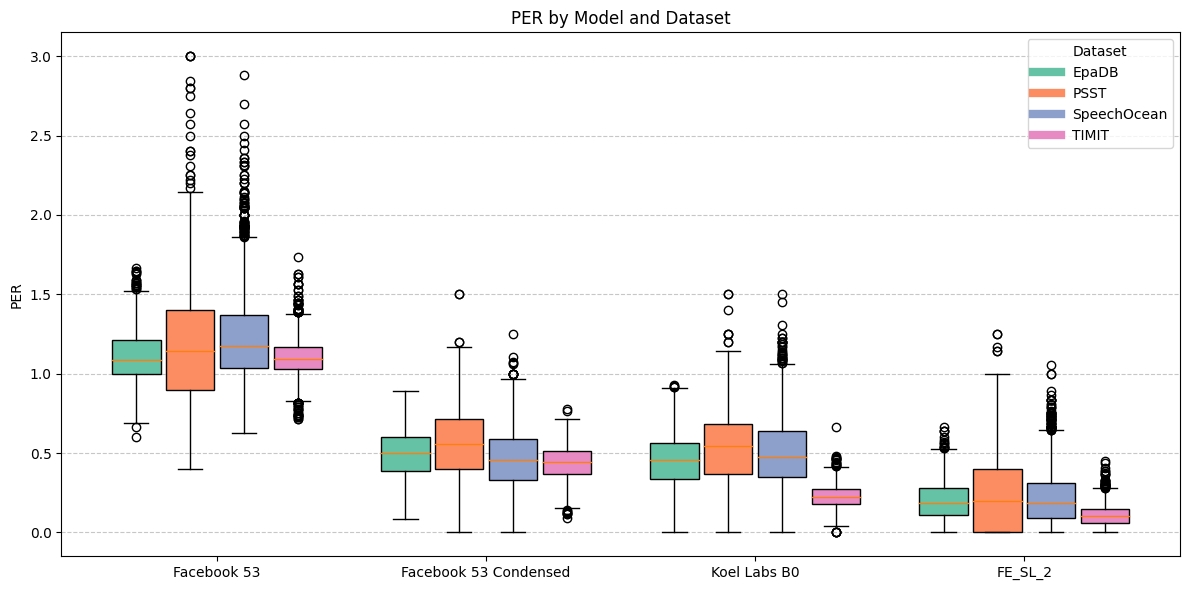

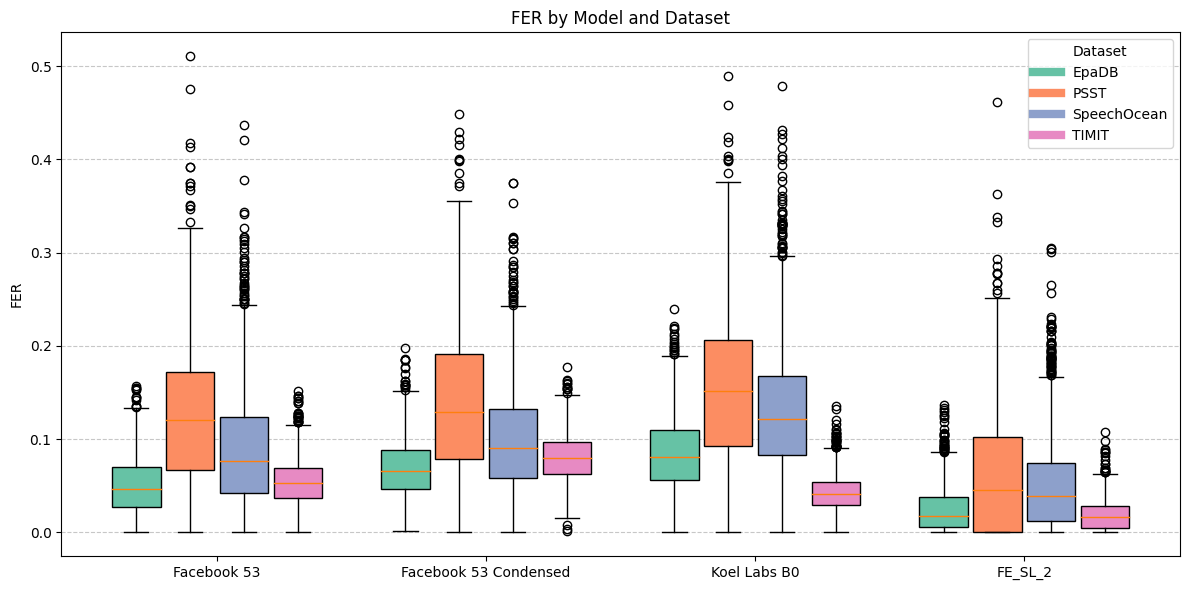

In [ ]:
# two box plots (one for per and one for fer) for each model and dataset combo
# models = ['Facebook 53', 'Facebook 60', 'Koel Labs B0', 'Vitouphy'] 
models = ['Facebook 53', 'Facebook 53 Condensed', 'Koel Labs B0', 'FE_SL_2'] 
# models = sorted(output_df['model_name'].unique())
datasets = sorted(output_df['dataset'].unique())
colors = sns.color_palette("Set2", len(datasets))

# Define helper function to create grouped boxplots
def plot_grouped_boxplots(metric: str, title: str):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    positions = []
    labels = []
    data = []
    current_pos = 0
    width = 4 / len(datasets)  # width per box within each group

    for model in models:
        for i, dataset in enumerate(datasets):
            subset = output_df[(output_df['model_name'] == model) & (output_df['dataset'] == dataset)]
            if not subset.empty:
                values = subset[metric].values
                values[values.argmax()] = values.mean() # eliminate top 1 outlier
                data.append(values)
                pos = current_pos + i * width
                positions.append(pos)
                labels.append(model if i == len(datasets) // 2 else "")  # Label model only once
        current_pos += width * len(datasets) + 1  # Add spacing between models

    # Flatten and plot each box individually with appropriate color
    bp = ax.boxplot(data, positions=positions, widths=width*0.9, patch_artist=True, manage_ticks=False)

    # Color boxes
    for i, box in enumerate(bp['boxes']):
        dataset_index = i % len(datasets)
        box.set(facecolor=colors[dataset_index])

    # Legend
    handles = [plt.Line2D([0], [0], color=color, lw=6) for color in colors] # type: ignore
    ax.legend(handles, datasets, title="Dataset")

    ax.set_title(title)
    ax.set_ylabel(metric.upper())
    ax.set_xticks(
        [np.mean(positions[i*len(datasets):(i+1)*len(datasets)]) for i in range(len(models))]
    )
    ax.set_xticklabels(models, rotation=0, ha='center')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot both PER and FER
plot_grouped_boxplots("per", "PER by Model and Dataset")
plot_grouped_boxplots("fer", "FER by Model and Dataset")

In [20]:
output_df.groupby(['model_name'])[['per', 'fer']].mean()

,per,fer
model_name,,
FE_NL_2,0.196635,0.039084
FE_SL_2,0.189265,0.037836
Facebook 53,1.150694,0.070206
Facebook 53 Condensed,0.476371,0.092330
Facebook 60,1.169307,0.076469
Ginic,0.410092,0.088948
Koel Labs B0,0.421819,0.099669
Rubino,0.586494,0.075940
Speech31,1.227223,0.117481


In [21]:
output_df.groupby(['dataset'])[['per', 'fer']].mean()

,per,fer
dataset,,
EpaDB,0.609839,0.058672
PSST,0.691075,0.127721
SpeechOcean,0.678520,0.095524
TIMIT,0.569277,0.050666


In [22]:
output_df.groupby(['dataset', 'model_name'])[['per', 'fer']].mean()

per       fer
dataset     model_name                               
EpaDB       FE_NL_2                0.184348  0.022051
            FE_SL_2                0.203223  0.025242
            Facebook 53            1.104416  0.051039
            Facebook 53 Condensed  0.489240  0.068878
            Facebook 60            1.108942  0.050660
            Ginic                  0.458957  0.074836
            Koel Labs B0           0.458319  0.084843
            Rubino                 0.590655  0.051719
            Speech31               1.151722  0.101243
            Taguchi                0.746699  0.092755
            UE_SL_3                0.205082  0.026055
            Vitouphy               0.616467  0.054741
PSST        FE_NL_2                0.244798  0.065197
            FE_SL_2                0.246254  0.064368
            Facebook 53            1.201650  0.127253
            Facebook 53 Condensed  0.558067  0.141370
            Facebook 60            1.161967  0.133529
            Ginic                  0.476107  0.135401
            Koel Labs B0           0.545545  0.155605
            Rubino                 0.778023  0.163966
            Speech31               1.311881  0.181403
            Taguchi                0.872330  0.174067
            UE_SL_3                0.269849  0.074379
            Vitouphy               0.625692  0.116167
SpeechOcean FE_NL_2                0.215588  0.051425
            FE_SL_2                0.219977  0.050136
            Facebook 53            1.234340  0.087451
            Facebook 53 Condensed  0.470946  0.099523
            Facebook 60            1.245720  0.092878
            Ginic                  0.456419  0.112649
            Koel Labs B0           0.502943  0.130948
            Rubino                 0.608011  0.081997
            Speech31               1.332452  0.140808
            Taguchi                0.895638  0.144324
            UE_SL_3                0.237496  0.055050
            Vitouphy               0.716795  0.098692
TIMIT       FE_NL_2                0.159258  0.023589
            FE_SL_2                0.111346  0.018893
            Facebook 53            1.096356  0.053599
            Facebook 53 Condensed  0.443069  0.080414
            Facebook 60            1.104573  0.049492
            Ginic                  0.279218  0.046552
            Koel Labs B0           0.226349  0.042883
            Rubino                 0.477188  0.051066
            Speech31               1.095548  0.070389
            Taguchi                0.731552  0.108278
            UE_SL_3                0.115724  0.020545
            Vitouphy               0.464065  0.039364